In [180]:
import praw
import pandas as pd
import re
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score


In [113]:
reddit = praw.Reddit(
    client_id='J6MtxI2aORRn-IQnBT3GIw',        
    client_secret='E2hmYe7VM0MZqAOBAg4KojcZg21LSQ',  
    user_agent='StockScraper:v1.0 by /u/shweta'      
)


subreddit_name = "stocks" 
subreddit = reddit.subreddit(subreddit_name)

# Scrape posts
posts = []
for post in subreddit.new(limit=100): 
    posts.append({
        "title": post.title,
        "score": post.score,
        "comments": post.num_comments,
        "url": post.url,
        "created": post.created_utc,
        "text": post.selftext
    })


posts_df = pd.DataFrame(posts)


csv_file = "reddit_data.csv"
posts_df.to_csv(csv_file, index=False)
print(f"Data has been saved to {csv_file}")


Data has been saved to reddit_data.csv


In [114]:
data = pd.read_csv("reddit_data.csv")

In [115]:
data.head(5)

,title,score,comments,url,created,text
0,What is fueling Duolingo's (DUOL) price?,1,0,https://www.reddit.com/r/stocks/comments/1h6in...,1.733326e+09,Duolingo is trading at ~200 PE for a market ca...
1,Do you guys believe we are in the beginning of...,12,67,https://www.reddit.com/r/stocks/comments/1h6hq...,1.733324e+09,While there are some signs pointing to a reces...
2,UnitedHealthcare CEO fatally shot,242,179,https://www.reddit.com/r/stocks/comments/1h6h6...,1.733322e+09,"“The CEO of UnitedHealthcare, Brian Thompson, ..."
3,These are the stocks on my watchlist (12/4),6,1,https://www.reddit.com/r/stocks/comments/1h6h1...,1.733322e+09,Hi! I am an ex-prop shop equity trader.\n\nThi...
4,Amazon sued by DC attorney general for alleged...,66,41,https://www.reddit.com/r/stocks/comments/1h6gi...,1.733320e+09,"Washington, D.C.’s attorney general sued Amazo..."


In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title     100 non-null    object 
 1   score     100 non-null    int64  
 2   comments  100 non-null    int64  
 3   url       100 non-null    object 
 4   created   100 non-null    float64
 5   text      100 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 4.8+ KB


In [117]:
data.isnull().sum()

title       0
score       0
comments    0
url         0
created     0
text        0
dtype: int64

In [118]:
data.describe()

,score,comments,created
count,100.000000,100.000000,1.000000e+02
mean,171.310000,122.580000,1.732915e+09
std,570.534442,279.368378,2.769738e+05
min,0.000000,0.000000,1.732405e+09
25%,5.750000,17.000000,1.732662e+09
50%,26.000000,44.500000,1.732895e+09
75%,119.000000,127.250000,1.733171e+09
max,5311.000000,2571.000000,1.733326e+09


In [119]:
data["text"] = data["text"].str.lower()
data["title"] = data["title"].str.lower()


In [121]:
def clean_text(text):
    return re.sub(r"[^a-zA-Z\s]", "", text)

data["title"] = data["title"].apply(clean_text)
data["text"] = data["text"].apply(clean_text)


In [122]:
nltk.download("punkt")

data["title_tokens"] = data["title"].apply(word_tokenize)
data["text_tokens"] = data["text"].apply(word_tokenize)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shwet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [123]:
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

data["title_tokens"] = data["title_tokens"].apply(
    lambda tokens: [word for word in tokens if word not in stop_words]
)
data["text_tokens"] = data["text_tokens"].apply(
    lambda tokens: [word for word in tokens if word not in stop_words]
)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shwet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [130]:
stemmer = PorterStemmer()

data["title_tokens"] = data["title_tokens"].apply(
    lambda tokens: [stemmer.stem(word) for word in tokens]
)
data["text_tokens"] = data["text_tokens"].apply(
    lambda tokens: [stemmer.stem(word) for word in tokens]
)


In [131]:
nltk.download("wordnet")

lemmatizer = WordNetLemmatizer()

data["title_tokens"] = data["title_tokens"].apply(
    lambda tokens: [lemmatizer.lemmatize(word) for word in tokens]
)
data["text_tokens"] = data["text_tokens"].apply(
    lambda tokens: [lemmatizer.lemmatize(word) for word in tokens]
)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shwet\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [132]:
data["content"] = data["title"] + " " + data["text"]

In [133]:
data["word_count"] = data["text"].apply(lambda x: len(x.split()))

In [134]:
nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()
data["sentiment_score"] = data["content"].apply(lambda x: sia.polarity_scores(x)["compound"])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shwet\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [135]:
def classify_sentiment(score):
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"

data["sentiment_label"] = data["sentiment_score"].apply(classify_sentiment)


In [136]:
data.to_csv("preprocessed_reddit_data.csv", index=False)
print("Preprocessed data saved to preprocessed_reddit_data.csv")

Preprocessed data saved to preprocessed_reddit_data.csv


In [137]:
data = pd.read_csv("preprocessed_reddit_data.csv")
print(data.head())


                                               title  score  comments  \
0              what is fueling duolingos duol price       1         0   
1  do you guys believe we are in the beginning of...     12        67   
2                  unitedhealthcare ceo fatally shot    242       179   
3              these are the stocks on my watchlist       6         1   
4  amazon sued by dc attorney general for alleged...     66        41   

                                                 url       created  \
0  https://www.reddit.com/r/stocks/comments/1h6in...  1.733326e+09   
1  https://www.reddit.com/r/stocks/comments/1h6hq...  1.733324e+09   
2  https://www.reddit.com/r/stocks/comments/1h6h6...  1.733322e+09   
3  https://www.reddit.com/r/stocks/comments/1h6h1...  1.733322e+09   
4  https://www.reddit.com/r/stocks/comments/1h6gi...  1.733320e+09   

                                                text  \
0  duolingo is trading at  pe for a market cap of...   
1  while there are some sign

In [138]:
nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\shwet\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [139]:
data["vader_sentiment_score"] = data["content"].apply(lambda x: sia.polarity_scores(x)["compound"])


def classify_vader_sentiment(score):
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"

data["vader_sentiment_label"] = data["vader_sentiment_score"].apply(classify_vader_sentiment)

print(data[["content", "vader_sentiment_score", "vader_sentiment_label"]].head())


                                             content  vader_sentiment_score  \
0  what is fueling duolingos duol price  duolingo...                 0.5423   
1  do you guys believe we are in the beginning of...                 0.0346   
2  unitedhealthcare ceo fatally shot the ceo of u...                -0.8555   
3  these are the stocks on my watchlist  hi i am ...                 0.3071   
4  amazon sued by dc attorney general for alleged...                -0.9343   

  vader_sentiment_label  
0              positive  
1               neutral  
2              negative  
3              positive  
4              negative  


In [140]:
# Calculate TextBlob polarity and subjectivity
data["textblob_polarity"] = data["content"].apply(lambda x: TextBlob(x).sentiment.polarity)
data["textblob_subjectivity"] = data["content"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

def classify_textblob_sentiment(polarity):
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

data["textblob_sentiment_label"] = data["textblob_polarity"].apply(classify_textblob_sentiment)

print(data[["content", "textblob_polarity", "textblob_sentiment_label"]].head())


                                             content  textblob_polarity  \
0  what is fueling duolingos duol price  duolingo...           0.190000   
1  do you guys believe we are in the beginning of...           0.165000   
2  unitedhealthcare ceo fatally shot the ceo of u...           0.000000   
3  these are the stocks on my watchlist  hi i am ...           0.053788   
4  amazon sued by dc attorney general for alleged...           0.051351   

  textblob_sentiment_label  
0                 positive  
1                 positive  
2                  neutral  
3                 positive  
4                 positive  


In [141]:
data.to_csv("reddit_sentiment_analysis.csv", index=False)
print("Sentiment analysis results saved to reddit_sentiment_analysis.csv")


Sentiment analysis results saved to reddit_sentiment_analysis.csv


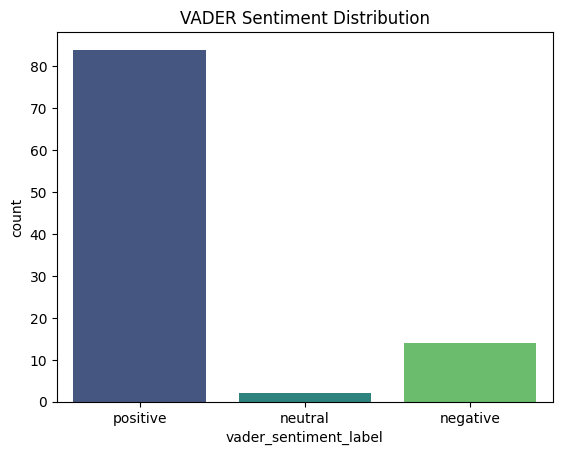

In [142]:
#sentiment label counts
sns.countplot(data=data, x="vader_sentiment_label", palette="viridis")
plt.title("VADER Sentiment Distribution")
plt.show()


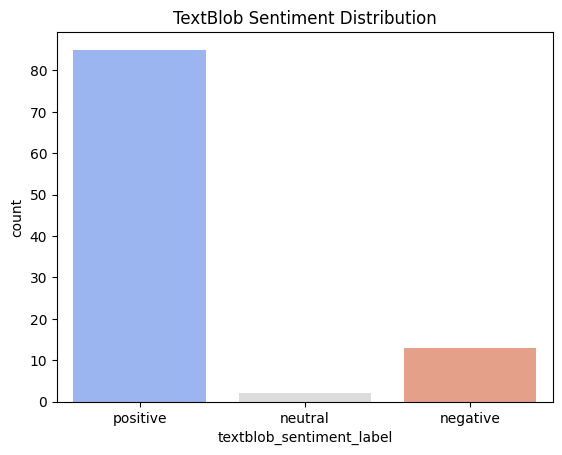

In [143]:
sns.countplot(data=data, x="textblob_sentiment_label", palette="coolwarm")
plt.title("TextBlob Sentiment Distribution")
plt.show()


In [144]:
# Analyze average upvotes for each sentiment
vader_sentiment_analysis = data.groupby("vader_sentiment_label")["score"].mean()
textblob_sentiment_analysis = data.groupby("textblob_sentiment_label")["score"].mean()

print("VADER Sentiment and Average Scores:")
print(vader_sentiment_analysis)

print("\nTextBlob Sentiment and Average Scores:")
print(textblob_sentiment_analysis)


VADER Sentiment and Average Scores:
vader_sentiment_label
negative    134.857143
neutral       6.000000
positive    181.321429
Name: score, dtype: float64

TextBlob Sentiment and Average Scores:
textblob_sentiment_label
negative    283.923077
neutral     180.500000
positive    153.870588
Name: score, dtype: float64


In [145]:
stock_data = pd.read_csv("finance.csv")
stock_data.head(4)

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Dec 2, 2024",237.27,240.79,237.16,239.59,239.59,"42,439,900"
1,"Nov 29, 2024",234.81,237.81,233.97,237.33,237.33,"28,481,400"
2,"Nov 27, 2024",234.47,235.69,233.81,234.93,234.93,"33,498,400"
3,"Nov 26, 2024",233.33,235.57,233.33,235.06,235.06,"45,986,200"


In [146]:
stock_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1510,"Jan 8, 2019",37.39,37.96,37.13,37.69,36.00,"164,101,200"
1511,"Jan 7, 2019",37.17,37.21,36.47,36.98,35.32,"219,111,200"
1512,"Jan 4, 2019",36.13,37.14,35.95,37.06,35.40,"234,428,400"
1513,"Jan 3, 2019",35.99,36.43,35.50,35.55,33.95,"365,248,800"
1514,"Jan 2, 2019",38.72,39.71,38.56,39.48,37.71,"148,158,800"


In [147]:
stock_data.isnull().sum()

Date          0
Open          0
High         25
Low          25
Close        25
Adj Close    25
Volume       25
dtype: int64

In [148]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

stock_data = stock_data[['Date', 'Close', 'Volume']]
stock_data.dropna(inplace=True)

print(stock_data.head())


        Date   Close      Volume
0 2024-12-02  239.59  42,439,900
1 2024-11-29  237.33  28,481,400
2 2024-11-27  234.93  33,498,400
3 2024-11-26  235.06  45,986,200
4 2024-11-25  232.87  90,152,800


In [149]:
stock_data.isnull().sum()

Date      0
Close     0
Volume    0
dtype: int64

In [150]:
sentiment_data = pd.read_csv("processed_sentiment_data.csv")
print(sentiment_data.head())
print(sentiment_data.columns)

                                               title  score  comments  \
0                                 Thoughts on DWL.L?      1         1   
1  r/Stocks Daily Discussion & Technicals Tuesday...      3         1   
2  Can someone please explain the process of recl...      4         2   
3  Rivian's potential $6.6 billion DoE loan catch...    360       103   
4  Raytheon awarded 1.3 Billion Navy / DOD contra...     30        16   

                                                 url       created  \
0  https://www.reddit.com/r/stocks/comments/1h5l2...  1.733224e+09   
1  https://www.reddit.com/r/stocks/comments/1h5kh...  1.733222e+09   
2  https://www.reddit.com/r/stocks/comments/1h5d9...  1.733194e+09   
3  https://www.reddit.com/r/stocks/comments/1h58s...  1.733181e+09   
4  https://www.reddit.com/r/stocks/comments/1h58a...  1.733180e+09   

                                                text  \
0  Is Dowlais Group Plc really undervalued, or am...   
1  This is the daily discuss

In [151]:
sentiment_data.head()

,title,score,comments,url,created,text,cleaned_text,textblob_polarity,vader_sentiment,sentiment_label
0,Thoughts on DWL.L?,1,1,https://www.reddit.com/r/stocks/comments/1h5l2...,1.733224e+09,"Is Dowlais Group Plc really undervalued, or am...",is dowlais group plc really undervalued or am ...,0.160556,0.6823,positive
1,r/Stocks Daily Discussion & Technicals Tuesday...,3,1,https://www.reddit.com/r/stocks/comments/1h5kh...,1.733222e+09,"This is the daily discussion, so anything stoc...",this is the daily discussion so anything stock...,0.009058,0.9648,positive
2,Can someone please explain the process of recl...,4,2,https://www.reddit.com/r/stocks/comments/1h5d9...,1.733194e+09,Hi guys. If you could please help me out i’d b...,hi guys if you could please help me out id be ...,0.014610,0.6078,positive
3,Rivian's potential $6.6 billion DoE loan catch...,360,103,https://www.reddit.com/r/stocks/comments/1h58s...,1.733181e+09,[Rivian's potential $6.6 billion DoE loan catc...,rivians potential billion doe loan catches ey...,-0.063328,0.7184,positive
4,Raytheon awarded 1.3 Billion Navy / DOD contra...,30,16,https://www.reddit.com/r/stocks/comments/1h58a...,1.733180e+09,Just released on the Department of Defense con...,just released on the department of defense con...,-0.032407,0.9808,positive


In [152]:
sentiment_data.rename(columns={"date": "Date"}, inplace=True)

In [153]:
num_rows = sentiment_data.shape[0]
start_date = "2023-01-01"

sentiment_data['Date'] = pd.date_range(start=start_date, periods=num_rows, freq='D')


In [154]:
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])

merged_data = pd.merge(sentiment_data, stock_data, on='Date', how='inner')
print(merged_data.head())


                                               title  score  comments  \
0  Can someone please explain the process of recl...      4         2   
1  Rivian's potential $6.6 billion DoE loan catch...    360       103   
2  Raytheon awarded 1.3 Billion Navy / DOD contra...     30        16   
3  Tesla CEO Elon Musk loses bid to get $56 billi...   4204       793   
4                       What do we think about IOVA?      0        15   

                                                 url       created  \
0  https://www.reddit.com/r/stocks/comments/1h5d9...  1.733194e+09   
1  https://www.reddit.com/r/stocks/comments/1h58s...  1.733181e+09   
2  https://www.reddit.com/r/stocks/comments/1h58a...  1.733180e+09   
3  https://www.reddit.com/r/stocks/comments/1h57c...  1.733177e+09   
4  https://www.reddit.com/r/stocks/comments/1h54h...  1.733170e+09   

                                                text  \
0  Hi guys. If you could please help me out i’d b...   
1  [Rivian's potential $6.6 

In [155]:
merged_data.head()

,title,score,comments,url,created,text,cleaned_text,textblob_polarity,vader_sentiment,sentiment_label,Date,Close,Volume
0,Can someone please explain the process of recl...,4,2,https://www.reddit.com/r/stocks/comments/1h5d9...,1.733194e+09,Hi guys. If you could please help me out i’d b...,hi guys if you could please help me out id be ...,0.014610,0.6078,positive,2023-01-03,125.07,"112,117,500"
1,Rivian's potential $6.6 billion DoE loan catch...,360,103,https://www.reddit.com/r/stocks/comments/1h58s...,1.733181e+09,[Rivian's potential $6.6 billion DoE loan catc...,rivians potential billion doe loan catches ey...,-0.063328,0.7184,positive,2023-01-04,126.36,"89,113,600"
2,Raytheon awarded 1.3 Billion Navy / DOD contra...,30,16,https://www.reddit.com/r/stocks/comments/1h58a...,1.733180e+09,Just released on the Department of Defense con...,just released on the department of defense con...,-0.032407,0.9808,positive,2023-01-05,125.02,"80,962,700"
3,Tesla CEO Elon Musk loses bid to get $56 billi...,4204,793,https://www.reddit.com/r/stocks/comments/1h57c...,1.733177e+09,"A Delaware judge ruled on Monday that Tesla, C...",a delaware judge ruled on monday that tesla ce...,0.183333,0.7335,positive,2023-01-06,129.62,"87,754,700"
4,What do we think about IOVA?,0,15,https://www.reddit.com/r/stocks/comments/1h54h...,1.733170e+09,"Firstly congrats everyone on RKLB, ACHR and LU...",firstly congrats everyone on rklb achr and lun...,0.126540,0.9952,positive,2023-01-09,130.15,"70,790,800"


In [158]:
merged_data['Prev_Close'] = merged_data['Close'].shift(1)
merged_data.dropna(inplace=True)

In [157]:
merged_data['Weighted_Sentiment'] = merged_data['score'] * merged_data['Volume']

In [159]:
# Remove commas 
merged_data['Volume'] = merged_data['Volume'].str.replace(',', '').astype(float)


In [160]:
merged_data['Prev_Close'] = pd.to_numeric(merged_data['Prev_Close'], errors='coerce')

merged_data['Sentiment_Score'] = pd.to_numeric(merged_data['score'], errors='coerce')
merged_data.dropna(inplace=True)


In [161]:
scaler = MinMaxScaler()

merged_data[['Sentiment_Score', 'Volume', 'Prev_Close']] = scaler.fit_transform(
    merged_data[['Sentiment_Score', 'Volume', 'Prev_Close']]
)


In [162]:
merged_data.columns

Index(['title', 'score', 'comments', 'url', 'created', 'text', 'cleaned_text',
       'textblob_polarity', 'vader_sentiment', 'sentiment_label', 'Date',
       'Close', 'Volume', 'Prev_Close', 'Weighted_Sentiment',
       'Sentiment_Score'],
      dtype='object')

In [163]:
merged_data['Price_Change'] = merged_data['Close'] - merged_data['Prev_Close']
merged_data['Stock_Price_Change'] = merged_data['Price_Change'].apply(lambda x: 1 if x > 0 else 0)


In [164]:
merged_data['Stock_Price_Change'] = merged_data['Close'].diff().apply(
    lambda x: 1 if x > 0 else 0
)


In [165]:
merged_data['Sentiment_Label'] = merged_data['Sentiment_Score'].apply(
    lambda x: 1 if x > 0 else 0
)


In [166]:
merged_data['Stock_Price_Change'].value_counts()

1    40
0    25
Name: Stock_Price_Change, dtype: int64

In [167]:
merged_data['Sentiment_Label'].value_counts()

1    53
0    12
Name: Sentiment_Label, dtype: int64

In [168]:
model = IsolationForest(random_state=42)
model.fit(X)  
predictions = model.predict(X) 


In [170]:
# Define X and target y
X = merged_data[['Sentiment_Score', 'Volume', 'Prev_Close']]
y = merged_data['Stock_Price_Change']


In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [176]:
print(y.value_counts())

1    40
0    25
Name: Stock_Price_Change, dtype: int64


In [177]:
y_train.value_counts()

1    32
0    20
Name: Stock_Price_Change, dtype: int64

In [190]:
X_train

,Sentiment_Score,Volume,Prev_Close
31,0.027355,0.211866,0.736574
59,0.003568,0.057674,0.792953
66,0.018792,0.024858,0.963305
61,0.003092,0.217187,0.907412
55,0.052093,0.206875,0.797327
45,0.002617,0.080790,0.676792
64,0.011656,0.059558,0.986877
60,0.004044,0.041178,0.868773
12,0.055423,0.322106,0.249089
9,0.000000,0.170522,0.236695


In [191]:
y_train

31    0
59    1
66    0
61    1
55    1
45    0
64    0
60    1
12    1
9     1
6     1
16    1
13    1
33    0
56    1
3     1
65    1
2     0
48    1
46    0
51    0
10    0
42    1
36    0
50    1
49    1
63    0
38    0
34    1
29    0
43    0
11    1
24    1
14    1
28    1
62    1
8     1
57    0
40    1
4     1
52    1
27    1
7     0
18    0
30    1
15    0
19    1
23    0
53    1
20    1
37    1
58    0
Name: Stock_Price_Change, dtype: int64

In [100]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Class Distribution After SMOTE:")
print(y_resampled.value_counts())


Class Distribution After SMOTE:
0    32
1    32
Name: Stock_Price_Change, dtype: int64


In [178]:
model = LogisticRegression(random_state=42)
model.fit(X_resampled, y_resampled)


LogisticRegression(random_state=42)

In [179]:
y_pred = model.predict(X_test)

In [183]:
print("Accuracy is :", accuracy_score(y_test, y_pred))
print(" ")
print( classification_report(y_test, y_pred))


Accuracy is : 0.8461538461538461
 
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.75      0.86         8

    accuracy                           0.85        13
   macro avg       0.86      0.88      0.85        13
weighted avg       0.89      0.85      0.85        13



In [184]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[5 0]
 [2 6]]


In [185]:
param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
grid = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5)
grid.fit(X_resampled, y_resampled)

print("Best Parameters:", grid.best_params_)


Best Parameters: {'C': 10, 'solver': 'liblinear'}


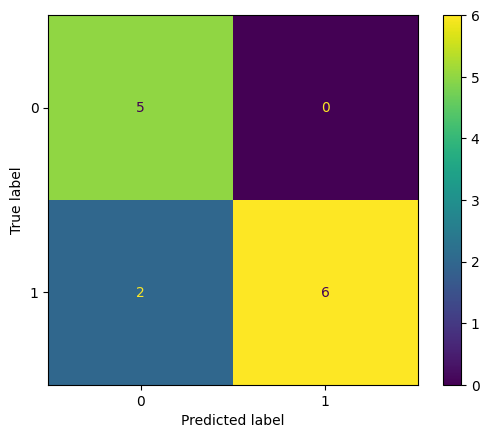

In [186]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.show()


# Saving the Model

In [187]:
import joblib

joblib.dump(model, "logistic_regression_model.pkl")


['logistic_regression_model.pkl']

In [ ]:
# 12 0.055423	0.322106	0.249089 output: 1

In [188]:
# Sample Model Prediction

In [193]:

new_data = [[0.055423, 0.322106, 0.249089]] 
prediction = model.predict(new_data)
print("Prediction:", prediction)


Prediction: [1]


C:\Users\shwet\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
